<a href="https://colab.research.google.com/github/mincfranc/DD_DataScience/blob/main/Project4__Spotify_Description_for_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Predicting Song Popularity in Pre-release Stage Using Tree-Based Regression Models.


# Problem Definition

The aim of Project 4 is to develop a predictive model for estimating the potential popularity of new songs prior to their release on Spotify.  

This is a supervised regression problem because we will train the model using pre-release features—such as artist followers and genre classifications—derived from existing songs. Actual popularity scores are excluded from the training process, instead focusing on how these features may indicate potential success for unreleased songs.

Objectives:

*  Identify and utilize relevant pre-release features that could indicate potential popularity.
* Implement Decision Tree and Random Forest regression models for predictions.
* Evaluate model performance using root mean squared error (RMSE) while minimizing overfitting through careful parameter selection.
* Analyze feature importance to uncover which characteristics are most predictive of potential popularity.

Business need: Accurate predictions of potential popularity can enhance marketing strategies and optimize resource allocation for new music launches, contributing to the field of music analytics.

#Data Source

> Load libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import graphviz
from IPython.display import display
import xgboost as xgb
import pickle
import re

> Load dataset from URL [Spotify.csv](https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv") into this Jupyter notebook

In [46]:
#Use command-line tool *curl* to retrieve data without downloading dataset

url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: qAGQgxFNozM2sicg2GCRbUcEFtda0X0sPD/3VeW17TX7bO0ynWOYR09tnJ2r2fBHkaPuUd4SnTE=
x-amz-request-id: DMWZ27F3E3N0ZTK3
Date: Tue, 05 Nov 2024 22:05:19 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Server: AmazonS3
Content-Length: 738124



> Dataframe: "spotify"

In [47]:
#READ url into pandas with dataframe "spotify"

spotify= pd.read_csv(url)

# Data Cleaning

> Explore data

In [48]:
#RETURN all columns with first 5 rows/records
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


###Review 1

> Review 1

* spotify df has 23 columns, 1556 rows, no nulls, categorical &  numerical data types, memory usage: 279.7+ KB

* The following columns appear likely not contributive to determining popularity of a NEW song which hasn't released hence no charting:

 "index, songID, highest charting, number times charted, week highest charting, streams, weeks charted, release date"

In [49]:
#RETURN df structure summaries
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [50]:
#RETURN list form with all df column titles
print(spotify.columns)

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')


In [51]:
#RETURN basic statistics
spotify.describe()

,Index,Highest Charting Position,Number of Times Charted
count,1556.000000,1556.000000,1556.000000
mean,778.500000,87.744216,10.668380
std,449.322824,58.147225,16.360546
min,1.000000,1.000000,1.000000
25%,389.750000,37.000000,1.000000
50%,778.500000,80.000000,4.000000
75%,1167.250000,137.000000,12.000000
max,1556.000000,200.000000,142.000000


> Dataframe copy= "spot_1"

In [52]:
#CREATE copy of dataframe
spot_1=spotify.copy()

In [53]:
#Verify df was copied
spot_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

> Variable with list of columns to drop: "drop_cols_1"

In [54]:
#CREATE list with columns to drop
drop_cols_1= ['Highest Charting Position', 'Number of Times Charted', 'Week of Highest Charting', 'Song Name', 'Streams', 'Song ID', 'Release Date', 'Weeks Charted', 'Artist']

> Drop Columns

* New df with dropped columns: "spot_1"
  *   14 columns,  1556 rows,  Zero nulls
*  memory usage dropped to: 170.3+ KB (from ~280KB)
*   used list "drop_cols_1" to drop 10 columns


In [55]:
#CREATE new df with dropped columns using "drop_cols_1"
spot_1= spot_1.drop(columns=drop_cols_1)
spot_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Index             1556 non-null   int64 
 1   Artist Followers  1556 non-null   object
 2   Genre             1556 non-null   object
 3   Popularity        1556 non-null   object
 4   Danceability      1556 non-null   object
 5   Energy            1556 non-null   object
 6   Loudness          1556 non-null   object
 7   Speechiness       1556 non-null   object
 8   Acousticness      1556 non-null   object
 9   Liveness          1556 non-null   object
 10  Tempo             1556 non-null   object
 11  Duration (ms)     1556 non-null   object
 12  Valence           1556 non-null   object
 13  Chord             1556 non-null   object
dtypes: int64(1), object(13)
memory usage: 170.3+ KB


In [56]:
#RETURN content from all columns for first 5 rows/records
spot_1.head()

,Index,Artist Followers,Genre,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,3377762,"['indie rock italiano', 'italian pop']",100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2230022,['australian hip hop'],99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,6266514,['pop'],99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,83293380,"['pop', 'uk pop']",98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5473565,"['lgbtq+ hip hop', 'pop rap']",96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


###Review 2

> Review 2

* Data types for 9 remaining columns are indicated as objects however the contents present as float.
    *  Transform columns 3 thru 11 to floats.

* "Genre" &  "Chord" have nested values.
    *  Parse values


> Transform Datatypes

In [57]:
# CREATE variable with columns to be converted to float
cols_to_float = [
    'Danceability', 'Energy', 'Loudness',
    'Speechiness', 'Acousticness',
    'Liveness', 'Tempo', 'Duration (ms)',
    'Valence', 'Artist Followers', 'Popularity'
]

# Convert to float
spot_1[cols_to_float] = spot_1[cols_to_float].apply(pd.to_numeric, errors='coerce')

# Display updated DataFrame & dtypes
print("\nUpdated DataFrame:")
print(spot_1.info())



Updated DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Index             1556 non-null   int64  
 1   Artist Followers  1545 non-null   float64
 2   Genre             1556 non-null   object 
 3   Popularity        1545 non-null   float64
 4   Danceability      1545 non-null   float64
 5   Energy            1545 non-null   float64
 6   Loudness          1545 non-null   float64
 7   Speechiness       1545 non-null   float64
 8   Acousticness      1545 non-null   float64
 9   Liveness          1545 non-null   float64
 10  Tempo             1545 non-null   float64
 11  Duration (ms)     1545 non-null   float64
 12  Valence           1545 non-null   float64
 13  Chord             1556 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 170.3+ KB
None


> Handling null values

After transforming dtypes, 11 new null values presented for all 9 transformed columns.

Identify and isolate rows with missing values in a specific columns



In [58]:
#Return specific location of missing values according to "Index" column

#List of specific column: "Index"
column_ind = [0]
column_ind

# Df to search for nulls in rows
find_rows = spot_1.isnull().any(axis=1)  #TRUE if null
find_rows

# Return only rows and columns with Nulls
selected= spot_1.loc[find_rows, spot_1.columns[column_ind]]

selected

,Index
35,36
163,164
464,465
530,531
636,637
654,655
750,751
784,785
876,877
1140,1141


In [59]:
#compare content & datatypes from original df to new df after conversion to numerical

value = spotify.iloc[35, 9]
print(value)

print(type(value))

value2= spot_1.iloc[35, 4]
print(value2)

print(type(value2))

#original df had an empty cell misclassified as string

 
<class 'str'>
nan
<class 'numpy.float64'>


> Drop 11 rows with nulls

In [60]:
drop_rows= [35, 163, 464, 530, 636, 654, 750, 784, 876, 1140, 1538]
spot_1= spot_1.drop(index=drop_rows)
spot_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Index             1545 non-null   int64  
 1   Artist Followers  1545 non-null   float64
 2   Genre             1545 non-null   object 
 3   Popularity        1545 non-null   float64
 4   Danceability      1545 non-null   float64
 5   Energy            1545 non-null   float64
 6   Loudness          1545 non-null   float64
 7   Speechiness       1545 non-null   float64
 8   Acousticness      1545 non-null   float64
 9   Liveness          1545 non-null   float64
 10  Tempo             1545 non-null   float64
 11  Duration (ms)     1545 non-null   float64
 12  Valence           1545 non-null   float64
 13  Chord             1545 non-null   object 
dtypes: float64(11), int64(1), object(2)
memory usage: 181.1+ KB


# Feature Engineering

Plan:
* Determine most frequently occurring genres:  
Extract & Explode nested Genres: separate the genres within each song and expand into individual rows, to simplify counting process.
* Count & Identify Top 10 Genres to make dataset manageable.
* Filter for only records with Top Genres.
* Re-aggregate data: to keep information about all relevant genres for each song while still retaining a clean format for later analysis.
* One-Hot Encoding for Clustering: Clustering requires a numeric format, and one-hot encoding is necessary for categorical variable "Genre". Each genre becomes a binary feature, so model recognizes genre presence across songs.

In [61]:
# **Ensure 'Genre' column is of string type before using .str accessor**
spot_1['Genre'] = spot_1['Genre'].astype(str)

# Data preprocessing: Extract and expand genres
all_genres= spot_1['Genre'].str.split(',')
genres_expanded = spot_1.explode('Genre').reset_index(drop=True)
genres_expanded['Genre'] = genres_expanded['Genre'].astype(str).str.strip()

# Count occurrences of each genre and get the top 10 genres
top_genres = genres_expanded['Genre'].value_counts().nlargest(10).index.tolist()

# Filter data for only records containing top genres
filtered_data = genres_expanded[genres_expanded['Genre'].isin(top_genres)].copy()

# Select relevant features for pre-release prediction
X = filtered_data[['Artist Followers']]
y = filtered_data['Popularity']  # 'Popularity' is target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features for better performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Decision Tree Regressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # Adjust max_depth as needed
tree_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = tree_model.predict(X_test_scaled)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# display feature importance
importance = tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance_df.sort_values(by='Importance', ascending=False))

#artist followers was the only predictor i used
#look at range of popularity values to consider rmse 9.67

RMSE: 12.110354695174296
            Feature  Importance
0  Artist Followers         1.0


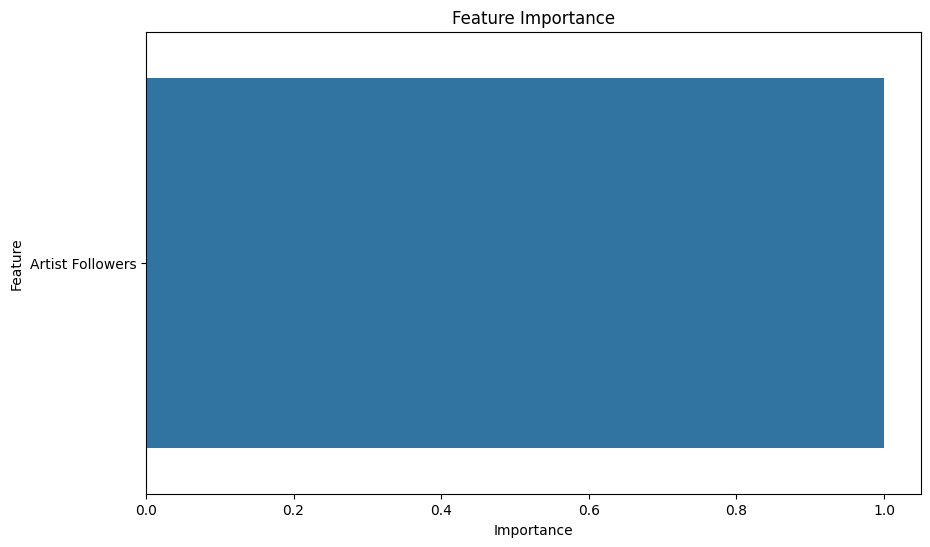

In [62]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

> Extract and Expand nested columns 'Genre' and 'Chords'

In [63]:
spot_1.dtypes

,0
Index,int64
Artist Followers,float64
Genre,object
Popularity,float64
Danceability,float64
Energy,float64
Loudness,float64
Speechiness,float64
Acousticness,float64
Liveness,float64


In [64]:
all_genres= (
 spot_1['Genre']
 .str.replace(r"['\[\]]","", regex = True)
#  .str.split(', ')
#  .explode('Genre')
#  .reset_index(drop=True)
 .str.get_dummies(sep=', ')
)
# remember you can add explode or get_dummies if you want more
# or value_counts()
all_genres

,a cappella,acoustic pop,adult standards,afrofuturism,afroswing,albanian hip hop,album rock,alt z,alternative metal,alternative pop rock,...,vancouver indie,vapor trap,vegas indie,venezuelan hip hop,viral pop,viral rap,vocal jazz,weirdcore,west coast rap,yacht rock
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
spot_1["Genre"].value_counts()

,count
Genre,
[],75
"['dance pop', 'pop', 'post-teen pop']",71
"['latin', 'reggaeton', 'trap latino']",63
"['pop', 'post-teen pop']",57
"['melodic rap', 'philly rap', 'rap', 'trap']",33
...,...
['tropical house'],1
"['brazilian hip hop', 'funk ostentacao']",1
"['australian pop', 'indie cafe pop', 'pop', 'pop rock', 'post-teen pop']",1


In [66]:
all_genres.shape

(1545, 334)

In [67]:
# Count the occurrences of each genre
top_genres = all_genres.sum().nlargest(10).index.tolist()
print("Top 10 Genres:", top_genres)

Top 10 Genres: ['pop', 'rap', 'dance pop', 'post-teen pop', 'pop rap', 'trap', 'reggaeton', 'trap latino', 'latin', 'hip hop']


In [68]:
all_genres.sum().sort_values(ascending= False)

,0
pop,485
rap,310
dance pop,257
post-teen pop,256
pop rap,164
...,...
perreo,1
funk 150 bpm,1
funk bh,1
pacific islands pop,1


In [69]:
all_genres.columns

Index(['a cappella', 'acoustic pop', 'adult standards', 'afrofuturism',
       'afroswing', 'albanian hip hop', 'album rock', 'alt z',
       'alternative metal', 'alternative pop rock',
       ...
       'vancouver indie', 'vapor trap', 'vegas indie', 'venezuelan hip hop',
       'viral pop', 'viral rap', 'vocal jazz', 'weirdcore', 'west coast rap',
       'yacht rock'],
      dtype='object', length=334)

drop chord and genre temporarily to run decision tree regression
pick a target and a feature

#Feature Selection

Select features for modeling and split the data into training and test sets.

In [70]:
# Define feature columns excluding 'Artist Followers'
features = spot_1.drop(columns=['Artist Followers'])
target = spot_1['Artist Followers']  # 'Artist Followers' is target for prediction

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Display shapes of train and test sets
print(X_train.shape, X_test.shape)


(1236, 13) (309, 13)


#Model Implementation
Implement and train the Decision Tree and Random Forest regression models

In [71]:
numerical_features = spot_1.select_dtypes(include=['number']).columns.drop('Artist Followers')
X = spot_1[numerical_features]
y = spot_1['Artist Followers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(X_train, y_train)

random_forest_model = RandomForestRegressor(random_state=42)
random_forest_model.fit(X_train, y_train)

# Make predictions
dt_predictions = decision_tree_model.predict(X_test)
rf_predictions = random_forest_model.predict(X_test)

# Calculate RMSE for both models
dt_rmse = np.sqrt(mean_squared_error(y_test, dt_predictions))
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

# Display RMSE results
print(f'Decision Tree RMSE: {dt_rmse}')
print(f'Random Forest RMSE: {rf_rmse}')

#with scaler the RMSE: 9.671977712613339
#        Feature          Importance
# 0  Artist Followers         1.0

Decision Tree RMSE: 23366675.988913648
Random Forest RMSE: 15150391.822269082


In [72]:
y.min(), y.max()

(4883.0, 83337783.0)

#Predictions and Evaluations
Make predictions and evaluate the models

##*Train Model with Pre-release Features*

RMSE: 10.622110991431144
            Feature  Importance
9  Artist Followers    0.812264
8           Valence    0.052902
2          Loudness    0.046056
0      Danceability    0.028046
3       Speechiness    0.027698
7     Duration (ms)    0.010606
5          Liveness    0.008986
4      Acousticness    0.008310
1            Energy    0.004196
6             Tempo    0.000935


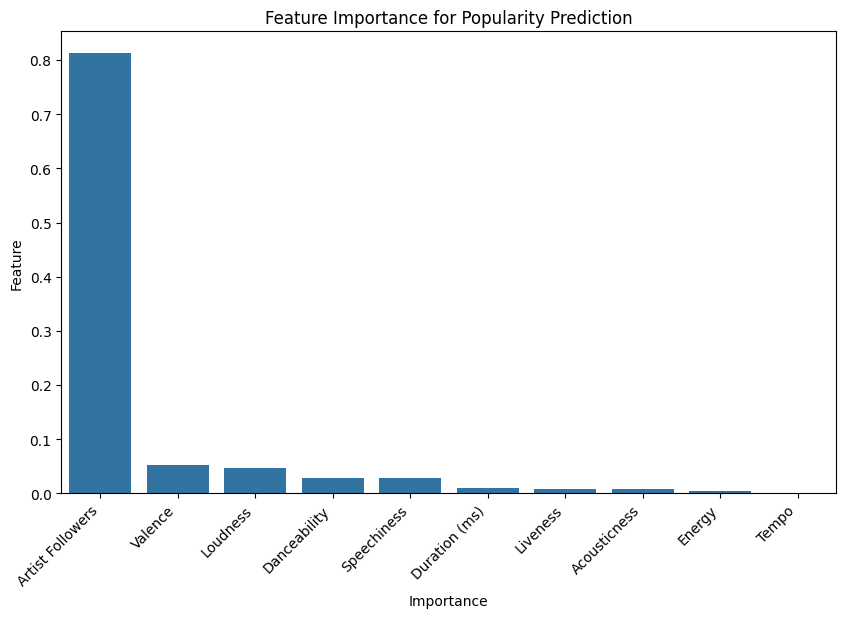

In [73]:
# Single Train-Test Split. No Scaling.

# Define predictors and target variable
predictors_2 = spot_1[['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Artist Followers']]
target_2 = spot_1['Popularity']

X = predictors_2
y = target_2

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree regressor
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Predict and evaluate model
y_pred = tree_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Calculate feature importance
importance = tree_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=feature_importance_df)#to print vertically
plt.title('Feature Importance for Popularity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels to 45 degrees
plt.show()

### Evaluate Performance of Decision Tree Regressor Model with Cross-Validation

CV RMSE, 5 deep:  11200.0

3 deep: 10880.0

In [74]:
# Cross-Validation evaluation. No scaling.

# Evaluate performance of Decision Tree Regressor model and identify the importance of different features in predicting song popularity using cross-validation for more robust estimate of the model's performance


target3 = spot_1['Popularity']
predictors3= spot_1[['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Artist Followers']]

X = predictors3
y = target3

numLoops = 500  #number of times to repeat crossvalidation

rms_error = np.zeros(numLoops)  #array stores RMSE for each iteration in loop

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2) #SPLIT
  model = DecisionTreeRegressor(max_depth=3) #CREATE MODEL
  model.fit(X_train,y_train)   #TRAIN MODEL X,y
  y_pred = model.predict(X_test)   #PREDICT on TEST X,y
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred)) #CALCULATE/STORE

print(f"CV RMSE: {rms_error.mean().round(2)}")


CV RMSE: 10.87


In [75]:

#Calculate feature importance
importance3 = model.feature_importances_
importance3

array([0.03197393, 0.01400488, 0.01335607, 0.01070544, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.92995969])

In [76]:
X.columns

Index(['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Artist Followers'],
      dtype='object')

In [77]:

feature_importance_df3 = pd.DataFrame({'Feature': X.columns, 'Importance': importance3})
feature_importance_df3.sort_values(by = "Importance", ascending=False)

,Feature,Importance
9,Artist Followers,0.929960
0,Danceability,0.031974
1,Energy,0.014005
2,Loudness,0.013356
3,Speechiness,0.010705
4,Acousticness,0.000000
5,Liveness,0.000000
6,Tempo,0.000000
7,Duration (ms),0.000000
8,Valence,0.000000


            Feature  Importance
9  Artist Followers    0.929960
0      Danceability    0.031974
1            Energy    0.014005
2          Loudness    0.013356
3       Speechiness    0.010705
4      Acousticness    0.000000
5          Liveness    0.000000
6             Tempo    0.000000
7     Duration (ms)    0.000000
8           Valence    0.000000


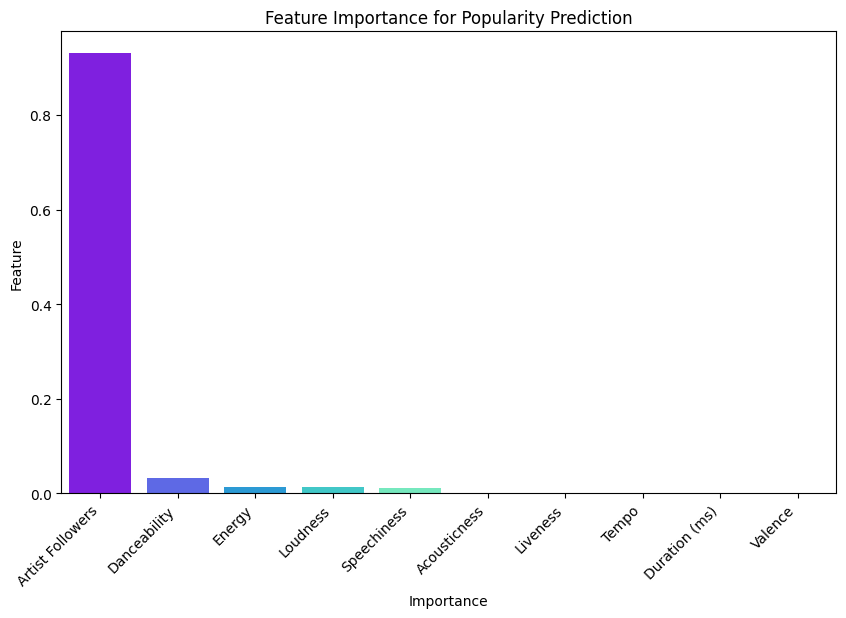

In [78]:

# Sort by importance
feature_importance_df3 = feature_importance_df3.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df3)

# Plot feature importance with rainbow colors
plt.figure(figsize=(10, 6))
num_features = len(feature_importance_df3)
colors = list(cm.rainbow(np.linspace(0, 1, num_features)))  # Convert to list
sns.barplot(x='Feature', y='Importance', data=feature_importance_df3, hue='Feature', palette=colors, dodge=False, legend=False)  # Apply rainbow colors, assign hue and set legend=False
plt.title('Feature Importance for Popularity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.show()


In [79]:
target3.min(), target3.max()

(0.0, 100.0)

#Analyze importance of features for the Random Forest model

CV RMSE: 10.87
            Feature  Importance
9  Artist Followers    0.913292
0      Danceability    0.033809
2          Loudness    0.019565
3       Speechiness    0.013214
1            Energy    0.011207
7     Duration (ms)    0.008913
4      Acousticness    0.000000
5          Liveness    0.000000
6             Tempo    0.000000
8           Valence    0.000000


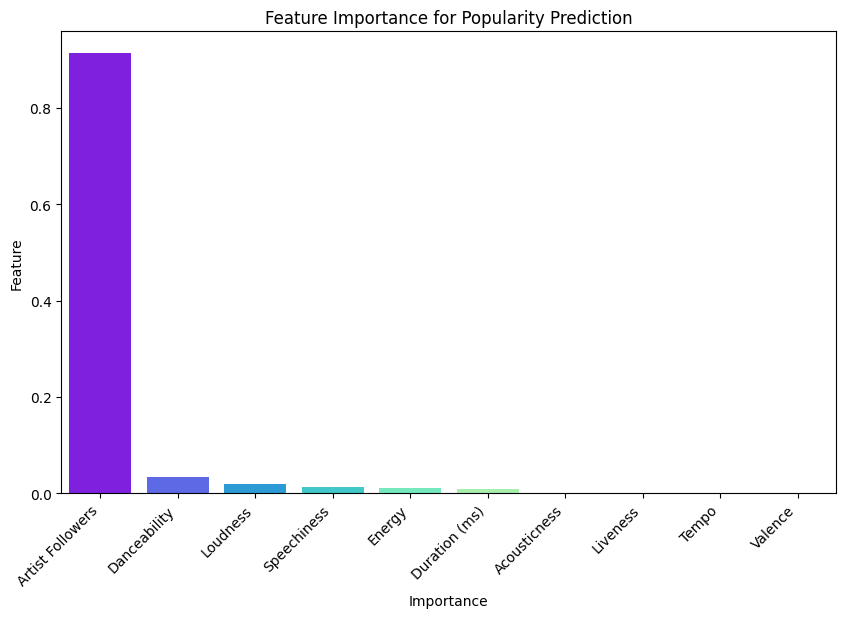

In [80]:
# Evaluate performance of Decision Tree Regressor with scaling and cross-validation

target3 = spot_1['Popularity']
predictors3 = spot_1[['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Artist Followers']]  # Exclude 'Genre' for scaling

X = predictors3
y = target3

numLoops = 500  # Number of times to repeat cross-validation

rms_error = np.zeros(numLoops)  # Array stores RMSE for each iteration

for idx in range(0, numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # Split

    # Create and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Transform the test data

    model = DecisionTreeRegressor(max_depth=3)  # Create model
    model.fit(X_train_scaled, y_train)  # Train model with scaled data
    y_pred = model.predict(X_test_scaled)  # Predict on scaled test data
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate/store RMSE

print(f"CV RMSE: {rms_error.mean().round(2)}")

# Calculate feature importance (using the last trained model)
importance3 = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df3 = pd.DataFrame({'Feature': X.columns, 'Importance': importance3})

# Sort by importance
feature_importance_df3 = feature_importance_df3.sort_values(by='Importance', ascending=False)

# Display feature importance
print(feature_importance_df3)

# Plot feature importance with rainbow colors
import matplotlib.cm as cm
plt.figure(figsize=(10, 6))
num_features = len(feature_importance_df3)
colors = list(cm.rainbow(np.linspace(0, 1, num_features)))  # Convert to list
sns.barplot(x='Feature', y='Importance', data=feature_importance_df3, hue='Feature', palette=colors, dodge=False, legend=False)  # Apply rainbow colors, assign hue and set legend=False
plt.title('Feature Importance for Popularity Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.show()